## layers

In [14]:
from keras.layers import Conv2D, normalization, ReLU, Dense, Dropout, Flatten, BatchNormalization, AvgPool2D
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras import backend as K

## 创建callback

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

## 将卷积网络的输出结果的最后一层卷积，可视化

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import keras.backend as K

import matplotlib.pyplot as mp
import cv2 as cv
import numpy as np

# 加载以训练好的resnet模型，基于imagenet
model = ResNet50(weights='imagenet')

# 测试图片路径
img_path = r'D:\softfiles\workspace\git\mypython\ml\data\objects\training\airplane\0013.jpg'
# 加载图片为PIL对象
img = image.load_img(img_path, target_size=(224, 224))
# 把pil转成array
x = image.img_to_array(img)
# 增加batch维度
x = np.expand_dims(x, axis=0)
# 处理成模型输入格式
x = preprocess_input(x)


# 模型预测
preds = model.predict(x)
# 获取概率前三的预测结果
print('Predicted:', decode_predictions(preds, top=3)[0])


## 以下内容，将实现可视化预测主要区域。将最终的预测输出，反向梯度传向最后一个conv层，本model即为add_16层，
# 获取最大概率预测的下标
argmax = np.argmax(presd[0])
# 获取最后一层argmax的输出结果
air_plane = model.output[:, argmax]
# 获取最后一个卷积层
last_conv_layer = model.get_layer('add_16')

# 将输出结果梯度传向最后的卷积层,去掉第一维[7, 7, 2048]
grads = K.gradients(air_plane, last_conv_layer.output)[0]
# 求梯度平均
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 构建新的输入，输出结构
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 将预测图片放入到新的结构中
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

# 归一化处理
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

mp.matshow(heatmap)
mp.show()

img = cv.imread(img_path)
heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv.imwrite('D://test.jpg', superimposed_img)

## Callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger

early_stopping = EarlyStopping(monitor='acc', patience=1)
checkpoint = ModelCheckpoint('D://test.h5', monitor='val_loss', save_best_only=True)
callbaocks_list = [early_stopping, checkpoint]

## TensorBoard

In [ ]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence

max_feature = 2000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_feature)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_feature, 128, input_length=max_len, name='embd'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

callbacks = [
    keras.callbacks.TensorBoard(
        log_dir=r'D:\softfiles\workspace\data\tensorflow\data\imdb\log',
        # record activation histogram every 1 epoch
        histogram_freq=1,
        # record embedding data every 1 epoch
        embeddings_freq=1
    )
]

history = model.fit(x_train, y_train, epochs=20, batch_size=128,
                   validation_split=0.2, callbacks=callbacks)

# Generative deep learning

In [26]:
import numpy as np

def reweight_distribution(origianl_distribution, temperature=0.5):
    distribution = np.log(origianl_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

In [27]:
import keras
import numpy as np

nie_path = r'D:\softfiles\workspace\data\tensorflow\data\generate\nietzsche.txt'
with open(nie_path, 'r') as f:
    text = f.read().lower()
print('coupus length: ', len(text))

coupus length:  600893


In [29]:
maxlen = 60
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

print('Number of sequences:', len(sentences))

chars = sorted(list(set(text)))
print('Unique characters:', len(chars))

char_indices = dict((char, chars.index(char)) for char in chars)

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 58
Vectorization...


In [38]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [58]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.01), loss='categorical_crossentropy')


In [60]:
import random
import sys

for epoch in range(1, 60):
    print('epoch', epoch)
    model.fit(x, y, batch_size=128, epochs=1)
    
    start_index = random.randint(0, len(text) - maxlen -1)
    generated_text = text[start_index: start_index + maxlen]
    print('---generating with seed:', generated_text)
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('---temperature:', temperature)
        sys.stdout.write(generated_text)
        
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1
                
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            generated_text += next_char
            generated_text = generated_text[1:]
            
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
Epoch 1/1
200278/200278 [==============================] - 326s 2ms/step - loss: 1.6430 8s - loss: 1.64 - - ETA: 3
---generating with seed: ustra, came!
     the world now laughs, the grisly veil was 
---temperature: 0.2
ustra, came!
     the world now laughs, the grisly veil was the most is the been the reality, and the man is all the ready the most problem and the the desires of the most have the the desires and man in the the the the same the the have the self-as the man is a most the greates of the contempt of the self-problem and the reality, the the man is the have the conturies the the interpretion of the most is the the the most is a many mankind the the great the 
---temperature: 0.5
ost is the the the most is a many mankind the the great the higher the self-reality the great objest or to ablimit
is the fact in the proble of the command, one have the does that the the have the soul, or any
of the onjohible self-the world and interpretion of the sense of the ready of th

KeyboardInterrupt: 

## Deep Dream

In [25]:
K.set_learning_phase?

In [1]:
# 使用inception_v3 no_top来实现deep dream，不需要额外训练
from keras.applications import inception_v3
import keras.backend as K

# 标识不训练网络
K.set_learning_phase(0)
# 加载以训练好的imagenet inception v3
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

# 使用graphic画出网络图
# from keras.utils import plot_model
# plot_model(model)

Using TensorFlow backend.


In [27]:
K.prod([2,3,4])

<tf.Tensor 'Prod_4:0' shape=() dtype=int32>

In [7]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5
}

# {layer.name, layer}
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [21]:
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [15]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1, 
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
        
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

In [43]:
import numpy as np

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 20.

base_image_path = 'final_dream.png'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for  i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
    unscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    
    lost_detail = same_size_original - unscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
# save_img(img, fname='final_dream.png')

D:\softfiles\programs\anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (458, 881)
...Loss value at 0 : 5.9632626
...Loss value at 1 : 8.822514
...Loss value at 2 : 10.425708
...Loss value at 3 : 11.470829
...Loss value at 4 : 12.418304
...Loss value at 5 : 13.244204
...Loss value at 6 : 14.025863
...Loss value at 7 : 14.730803
...Loss value at 8 : 15.385887
...Loss value at 9 : 16.005175
...Loss value at 10 : 16.60982
...Loss value at 11 : 17.18968
...Loss value at 12 : 17.71523
...Loss value at 13 : 18.26224
...Loss value at 14 : 18.770668
...Loss value at 15 : 19.269463
...Loss value at 16 : 19.744278


D:\softfiles\programs\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:27: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Processing image shape (641, 1234)
...Loss value at 0 : 5.640499
...Loss value at 1 : 8.156164
...Loss value at 2 : 9.872185
...Loss value at 3 : 11.122672
...Loss value at 4 : 12.233078
...Loss value at 5 : 13.183662
...Loss value at 6 : 14.061219
...Loss value at 7 : 14.852155
...Loss value at 8 : 15.601908
...Loss value at 9 : 16.297981
...Loss value at 10 : 16.956245
...Loss value at 11 : 17.576717
...Loss value at 12 : 18.201435
...Loss value at 13 : 18.775219
...Loss value at 14 : 19.330278
...Loss value at 15 : 19.861671
Processing image shape (898, 1728)
...Loss value at 0 : 5.0553474
...Loss value at 1 : 7.14549
...Loss value at 2 : 8.713226
...Loss value at 3 : 9.932522
...Loss value at 4 : 11.02048
...Loss value at 5 : 11.996721
...Loss value at 6 : 12.894331
...Loss value at 7 : 13.71944
...Loss value at 8 : 14.497849
...Loss value at 9 : 15.229874
...Loss value at 10 : 15.913263
...Loss value at 11 : 16.566832
...Loss value at 12 : 17.194614
...Loss value at 13 : 17.79987


## Neural style transfer

```python
# define a loss function
loss = distance(style(reference_image) - style(generated_image)) + 
       distance(content(original_image) - content(generated_image))
```

In [1]:
# Defining some initial variables
from keras.preprocessing.image import load_img, img_to_array

target_image_path = 'D:\\target.jpg'
style_reference_image_path = 'D:\\style.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Using TensorFlow backend.


In [6]:
# define suxiliary functions
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # remove zero center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR' -> 'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
print('Model loader.')

Model loader.


In [8]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width -1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [9]:
# define the final loss that we will minimize
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.0)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, ...]
loss += content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    s1 = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * s1
loss += total_variation_weight * total_variation_loss(combination_image)

In [15]:
# setting up the gradient descent process
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [16]:
evaluator = Evaluator()

In [18]:
# the style transfer loop
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i , end_time - start_time))

Start of iteration 0
Current loss value: 87286070000.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 27s
Start of iteration 1


D:\softfiles\programs\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 20880833000.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 27s
Start of iteration 2
Current loss value: 10529188000.0
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 28s
Start of iteration 3
Current loss value: 7189771300.0
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 28s
Start of iteration 4
Current loss value: 5683388400.0
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 27s
Start of iteration 5
Current loss value: 4676994000.0
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 28s
Start of iteration 6
Current loss value: 3981145000.0
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 27s
Start of iteration 7
Current loss value: 3443040500.0
Image saved as my_result_at_iteration_7.png
Iteration 7 completed in 28s
Start of iteration 8
Current loss value: 3041090300.0
Image saved as my_result_at_iteration_8.png
Iteration 8 completed in 30s
Sta

## Generating images with variational autoencoders

In [2]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [9]:
# decoder network, mapping latent space points to images
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [10]:
# a custom layer used to compute the vae  loss
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        k1_loss = -5e-4 * K.mean(1+z_log_var - K.square(z_mean)-K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + k1_loss)
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [11]:
# training the vae
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

mnist_path = r'D:\softfiles\workspace\data\tensorflow\data\mnist_data\mnist.npz'
with np.load(mnist_path) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

In [12]:
vae.fit(x_train, None, shuffle=True, epochs=10, batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 128s 2ms/step - loss: 0.2095 - val_loss: 0.1967
Epoch 2/10
60000/60000 [==============================] - 127s 2ms/step - loss: 0.1931 - val_loss: 0.1899
Epoch 3/10
60000/60000 [==============================] - 134s 2ms/step - loss: 0.1888 - val_loss: 0.1871
Epoch 4/10
60000/60000 [==============================] - 136s 2ms/step - loss: 0.1862 - val_loss: 0.1848
Epoch 5/10
60000/60000 [==============================] - 136s 2ms/step - loss: 0.1845 - val_loss: 0.1833
Epoch 6/10
60000/60000 [==============================] - 139s 2ms/step - loss: 0.1831 - val_loss: 0.1826
Epoch 7/10
60000/60000 [==============================] - 143s 2ms/step - loss: 0.1822 - val_loss: 0.1837
Epoch 8/10
60000/60000 [==============================] - 139s 2ms/step - loss: 0.1814 - val_loss: 0.1808
Epoch 9/10
60000/60000 [==============================] - 140s 2ms/step - loss: 0.1807 - val_loss: 0.1

In [18]:
grid_x

array([-1.64485363e+00, -1.20404696e+00, -9.20822976e-01, -6.97141435e-01,
       -5.03965367e-01, -3.28072108e-01, -1.61844167e-01, -1.39145821e-16,
        1.61844167e-01,  3.28072108e-01,  5.03965367e-01,  6.97141435e-01,
        9.20822976e-01,  1.20404696e+00,  1.64485363e+00])

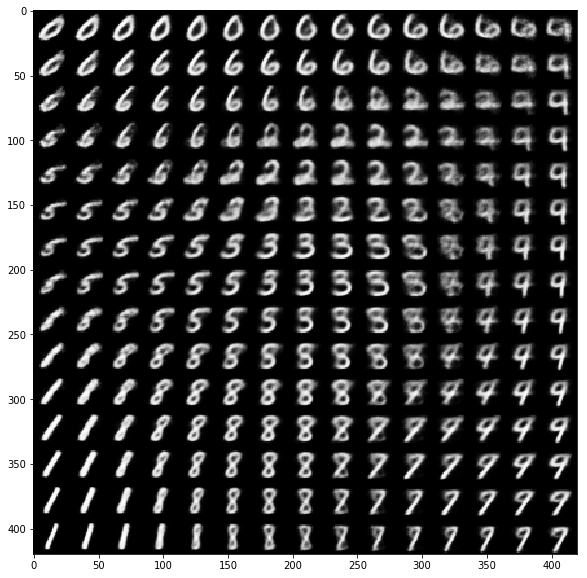

In [15]:
import matplotlib.pyplot as mp
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        
mp.figure(figsize=(10, 10))
mp.imshow(figure, cmap='Greys_r')
mp.show()